In [1]:
#Import Libraries

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Initialize Constants

DATA_FOLDER_AUGMENTED = 'final_data'  # Path to augmented data directory
DATA_FOLDER_SMOTE = 'smote_data'  # Path to SMOTE data directory
IMG_SIZE = (224, 224)  # Standard image size for ResNet50 and VGG16
BATCH_SIZE = 32  # Adjust based on your system's capabilities
EPOCHS = 30  # Number of epochs for training


In [2]:
#Function for Preparing Data for Augmented Dataset
def prepare_data_augmented(data_folder, img_size, batch_size):
    datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                 validation_split=0.2)

    train_generator = datagen.flow_from_directory(
        data_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        data_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    return train_generator, validation_generator

#Function for Preparing Data for SMOTE Dataset
def prepare_data_smote(data_folder, img_size, batch_size):
    datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                 validation_split=0.2)

    train_generator = datagen.flow_from_directory(
        data_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        data_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    return train_generator, validation_generator


In [3]:
#Function to Set Up ResNet50 Model
def setup_resnet_model(train_data, img_size):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,))
    base_model.trainable = False  # Freeze the base model layers

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 neurons
    predictions = Dense(train_data.num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

#Function to Set Up VGG16 Model
def setup_vgg_model(train_data, img_size):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,))
    base_model.trainable = False  # Freeze the base model layers

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 neurons
    x = Dropout(0.5)(x)  # Dropout layer
    predictions = Dense(train_data.num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=predictions)
    return model



In [4]:
#Function to Compile, Train, and Save ResNet50 Model on Augmented Data
def compile_train_save_resnet_augmented(train_generator, val_generator):
    model = setup_resnet_model(train_generator, IMG_SIZE)
    checkpoint = ModelCheckpoint('resnet_augmented_best_model.h5', monitor='val_accuracy', save_best_only=True)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpoint]
    )
    return history, model

# Cell 8: Function to Compile, Train, and Save ResNet50 Model on SMOTE Data
def compile_train_save_resnet_smote(train_generator, val_generator):
    model = setup_resnet_model(train_generator, IMG_SIZE)
    checkpoint = ModelCheckpoint('resnet_smote_best_model.h5', monitor='val_accuracy', save_best_only=True)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpoint]
    )
    return history, model

    
#Function to Compile, Train, and Save VGG16 Model on Augmented Data
def compile_train_save_vgg_augmented(train_generator, val_generator):
    model = setup_vgg_model(train_generator, IMG_SIZE)
    checkpoint = ModelCheckpoint('vgg_augmented_best_model.h5', monitor='val_accuracy', save_best_only=True)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpoint]
    )
    return history, model

#Function to Compile, Train, and Save VGG16 Model on SMOTE Data
def compile_train_save_vgg_smote(train_generator, val_generator):
    model = setup_vgg_model(train_generator, IMG_SIZE)
    checkpoint = ModelCheckpoint('vgg_smote_best_model.h5', monitor='val_accuracy', save_best_only=True)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpoint]
    )
    return history, model




In [5]:
#Function to Evaluate ResNet50 Model on Augmented Data
def evaluate_model_resnet_augmented(val_generator):
    # Load the best model
    model = load_model('resnet_augmented_best_model.h5')

    # Evaluate the model
    val_predictions = model.predict(val_generator)
    val_labels = np.argmax(val_predictions, axis=1)
    true_labels = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())

    # Print the confusion matrix and classification report
    print("Confusion Matrix for ResNet50 on Augmented Data")
    print(confusion_matrix(true_labels, val_labels))
    print("\nClassification Report for ResNet50 on Augmented Data")
    print(classification_report(true_labels, val_labels, target_names=class_labels))
    
#Function to Evaluate ResNet50 Model on SMOTE Data
def evaluate_model_resnet_smote(val_generator):
    # Load the best model
    model = load_model('resnet_smote_best_model.h5')

    # Evaluate the model
    val_predictions = model.predict(val_generator)
    val_labels = np.argmax(val_predictions, axis=1)
    true_labels = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())

    # Print the confusion matrix and classification report
    print("Confusion Matrix for ResNet50 on Augmented Data")
    print(confusion_matrix(true_labels, val_labels))
    print("\nClassification Report for ResNet50 on Augmented Data")
    print(classification_report(true_labels, val_labels, target_names=class_labels))
    
#Function to Evaluate VGG16 Model on Augmented Data
def evaluate_model_vgg_augmented(val_generator):
    # Load the best model
    model = load_model('vgg_augmented_best_model.h5')

    # Evaluate the model
    val_predictions = model.predict(val_generator)
    val_labels = np.argmax(val_predictions, axis=1)
    true_labels = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())

    # Print the confusion matrix and classification report
    print("Confusion Matrix for VGG16 on Augmented Data")
    print(confusion_matrix(true_labels, val_labels))
    print("\nClassification Report for VGG16 on Augmented Data")
    print(classification_report(true_labels, val_labels, target_names=class_labels))

#Function to Evaluate VGG16 Model on SMOTE Data
def evaluate_model_vgg_smote(val_generator):
    # Load the best model
    model = load_model('vgg_smote_best_model.h5')

    # Evaluate the model
    val_predictions = model.predict(val_generator)
    val_labels = np.argmax(val_predictions, axis=1)
    true_labels = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())

    # Print the confusion matrix and classification report
    print("Confusion Matrix for VGG16 on Augmented Data")
    print(confusion_matrix(true_labels, val_labels))
    print("\nClassification Report for VGG16 on Augmented Data")
    print(classification_report(true_labels, val_labels, target_names=class_labels))

In [6]:
#Function to Visualize Training Process for ResNet50 on Augmented Data
def visualize_training_resnet_augmented(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy for ResNet50 on Augmented Data')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss for ResNet50 on Augmented Data')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

#Function to Visualize Training Process for ResNet50 on SMOTE Data
def visualize_training_resnet_smote(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy for ResNet50 on Smote Data')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss for ResNet50 on Smote Data')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def visualize_training_vgg_augmented(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy for VGG16 on Augmented Data')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss for VGG16 on Augmented Data')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def visualize_training_vgg_smote(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy for VGG16 on Smote Data')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss for VGG16 on Smote Data')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


In [7]:
#Prepare data

train_gen_augmented, val_gen_augmented = prepare_data_augmented(DATA_FOLDER_AUGMENTED, IMG_SIZE, BATCH_SIZE)

train_gen_smote, val_gen_smote = prepare_data_smote(DATA_FOLDER_SMOTE, IMG_SIZE, BATCH_SIZE)



Found 1061 images belonging to 6 classes.
Found 263 images belonging to 6 classes.
Found 618 images belonging to 6 classes.
Found 150 images belonging to 6 classes.


Epoch 1/15
33/33 [==============================] - 123s 3s/step - loss: 2.9499 - accuracy: 0.3168 - val_loss: 1.6400 - val_accuracy: 0.3711
Epoch 2/15
33/33 [==============================] - 95s 3s/step - loss: 1.4966 - accuracy: 0.4091 - val_loss: 1.4526 - val_accuracy: 0.3750
Epoch 3/15
33/33 [==============================] - 86s 3s/step - loss: 1.4171 - accuracy: 0.4461 - val_loss: 1.4144 - val_accuracy: 0.3672
Epoch 4/15
33/33 [==============================] - 89s 3s/step - loss: 1.3200 - accuracy: 0.4636 - val_loss: 1.3761 - val_accuracy: 0.4336
Epoch 5/15
33/33 [==============================] - 94s 3s/step - loss: 1.2467 - accuracy: 0.4962 - val_loss: 1.4166 - val_accuracy: 0.4141
Epoch 6/15
33/33 [==============================] - 87s 3s/step - loss: 1.1720 - accuracy: 0.5549 - val_loss: 1.3467 - val_accuracy: 0.4453
Epoch 7/15
33/33 [==============================] - 87s 3s/step - loss: 1.1315 - accuracy: 0.5607 - val_loss: 1.3768 - val_accuracy: 0.4375
Epoch 8/15
33/33 [=

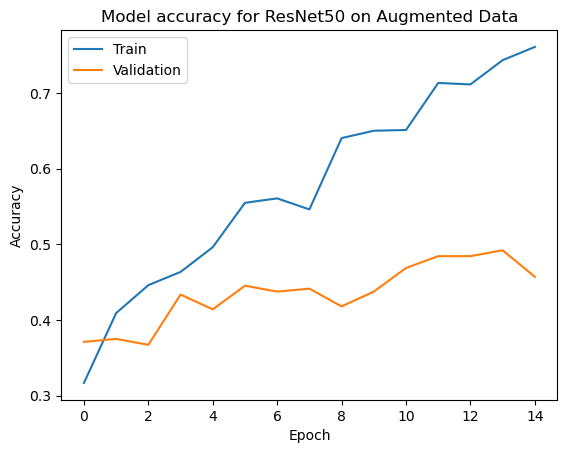

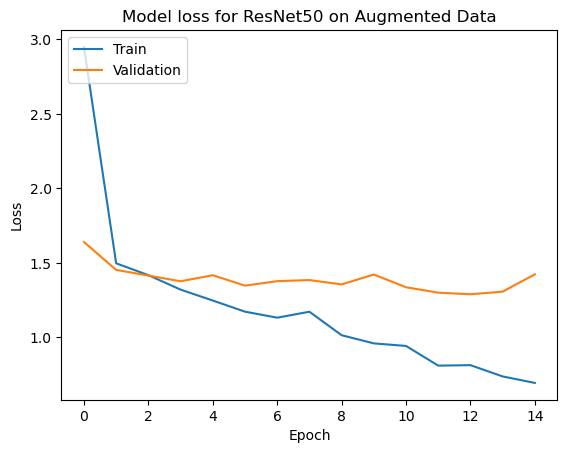

In [8]:
#Execute Training and Evaluation for ResNet50 on Augmented Data

history_resnet_augmented, model_resnet_augmented = compile_train_save_resnet_augmented(train_gen_augmented, val_gen_augmented)
evaluate_model_resnet_augmented(val_gen_augmented)

#Visualize Training for ResNet50 on Augmented Data
visualize_training_resnet_augmented(history_resnet_augmented)


Epoch 1/15
19/19 [==============================] - 57s 3s/step - loss: 2.9952 - accuracy: 0.2201 - val_loss: 1.7551 - val_accuracy: 0.3047
Epoch 2/15
19/19 [==============================] - 48s 3s/step - loss: 1.3523 - accuracy: 0.4778 - val_loss: 1.6105 - val_accuracy: 0.3281
Epoch 3/15
19/19 [==============================] - 45s 2s/step - loss: 1.1002 - accuracy: 0.5819 - val_loss: 1.5849 - val_accuracy: 0.3438
Epoch 4/15
19/19 [==============================] - 46s 2s/step - loss: 0.9939 - accuracy: 0.6519 - val_loss: 1.4251 - val_accuracy: 0.4844
Epoch 5/15
19/19 [==============================] - 46s 2s/step - loss: 0.8369 - accuracy: 0.6962 - val_loss: 1.4228 - val_accuracy: 0.5234
Epoch 6/15
19/19 [==============================] - 45s 2s/step - loss: 0.7604 - accuracy: 0.7304 - val_loss: 1.4744 - val_accuracy: 0.4688
Epoch 7/15
19/19 [==============================] - 46s 2s/step - loss: 0.7110 - accuracy: 0.7474 - val_loss: 1.4408 - val_accuracy: 0.4609
Epoch 8/15
19/19 [==

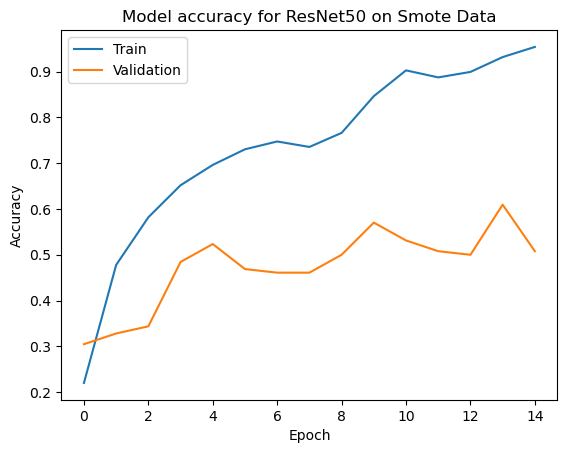

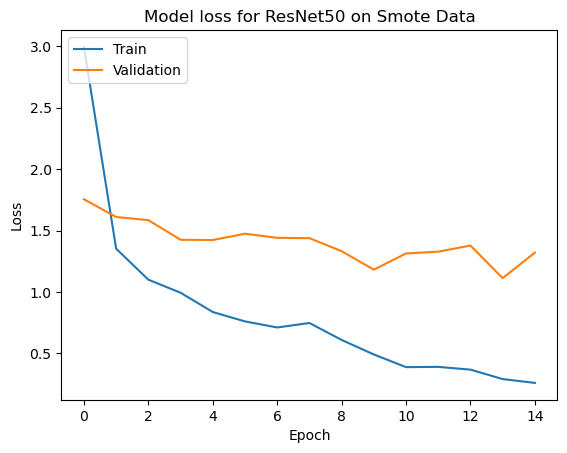

In [9]:
#Execute Training and Evaluation for ResNet50 on SMOTE Data

history_resnet_smote, model_resnet_smote = compile_train_save_resnet_smote(train_gen_smote, val_gen_smote)
evaluate_model_resnet_smote(val_gen_smote)

#Visualize Training for ResNet50 on SMOTE Data
visualize_training_resnet_smote(history_resnet_smote)

Epoch 1/15
33/33 [==============================] - 231s 7s/step - loss: 4.1563 - accuracy: 0.2576 - val_loss: 1.7552 - val_accuracy: 0.3984
Epoch 2/15
33/33 [==============================] - 216s 7s/step - loss: 2.1547 - accuracy: 0.3362 - val_loss: 1.7103 - val_accuracy: 0.4023
Epoch 3/15
33/33 [==============================] - 213s 6s/step - loss: 1.5910 - accuracy: 0.3936 - val_loss: 1.3534 - val_accuracy: 0.4297
Epoch 4/15
33/33 [==============================] - 214s 7s/step - loss: 1.3889 - accuracy: 0.4441 - val_loss: 1.3245 - val_accuracy: 0.4609
Epoch 5/15
33/33 [==============================] - 552s 17s/step - loss: 1.2994 - accuracy: 0.4762 - val_loss: 1.2914 - val_accuracy: 0.5195
Epoch 6/15
33/33 [==============================] - 212s 6s/step - loss: 1.2575 - accuracy: 0.5131 - val_loss: 1.2826 - val_accuracy: 0.4922
Epoch 7/15
33/33 [==============================] - 216s 7s/step - loss: 1.1520 - accuracy: 0.5646 - val_loss: 1.2439 - val_accuracy: 0.5000
Epoch 8/15
3

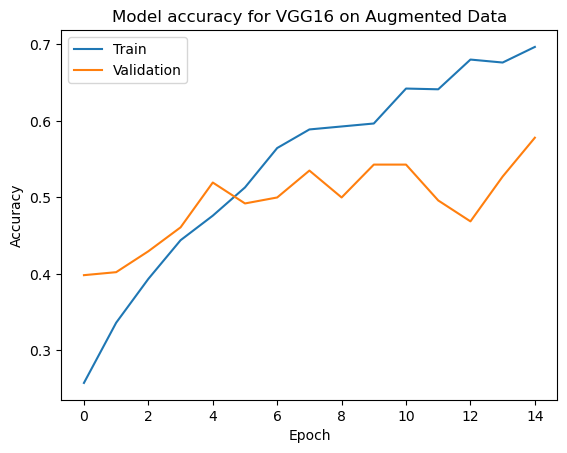

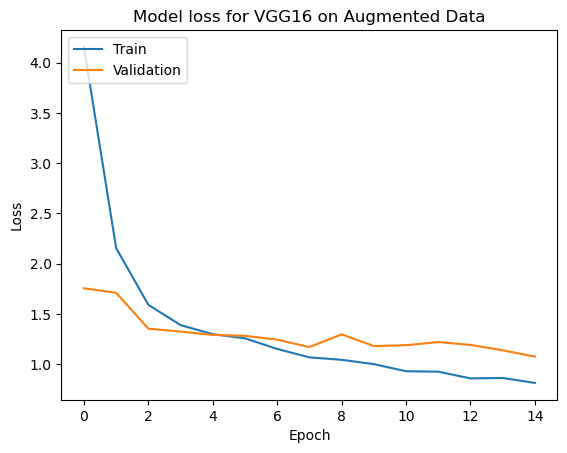

In [10]:
#Execute Training and Evaluation for VGG16 on Augmented Data
history_vgg_augmented, model_vgg_augmented = compile_train_save_vgg_augmented(train_gen_augmented, val_gen_augmented)
evaluate_model_vgg_augmented(val_gen_augmented)

#Visualize Training for VGG16 on Augmented Data
visualize_training_vgg_augmented(history_vgg_augmented)

Epoch 1/15
19/19 [==============================] - 127s 7s/step - loss: 5.1905 - accuracy: 0.2031 - val_loss: 3.3130 - val_accuracy: 0.2266
Epoch 2/15
19/19 [==============================] - 125s 7s/step - loss: 2.4028 - accuracy: 0.3447 - val_loss: 2.5258 - val_accuracy: 0.2266
Epoch 3/15
19/19 [==============================] - 130s 7s/step - loss: 1.7207 - accuracy: 0.4898 - val_loss: 1.8399 - val_accuracy: 0.3281
Epoch 4/15
19/19 [==============================] - 132s 7s/step - loss: 1.2892 - accuracy: 0.5137 - val_loss: 1.5704 - val_accuracy: 0.4375
Epoch 5/15
19/19 [==============================] - 129s 7s/step - loss: 1.0396 - accuracy: 0.5973 - val_loss: 1.6134 - val_accuracy: 0.3906
Epoch 6/15
19/19 [==============================] - 123s 7s/step - loss: 0.8750 - accuracy: 0.6570 - val_loss: 1.3231 - val_accuracy: 0.5156
Epoch 7/15
19/19 [==============================] - 127s 7s/step - loss: 0.7935 - accuracy: 0.7184 - val_loss: 1.2329 - val_accuracy: 0.5781
Epoch 8/15
19

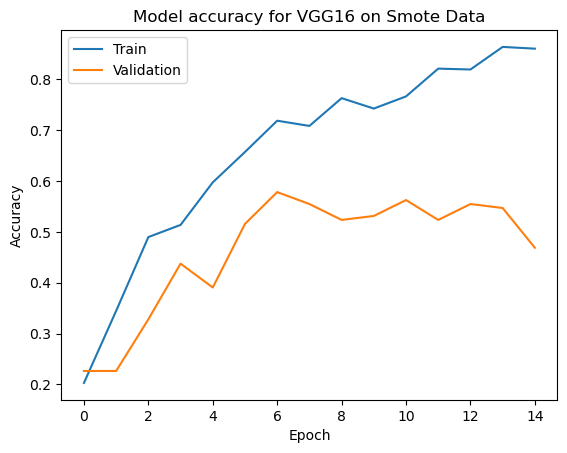

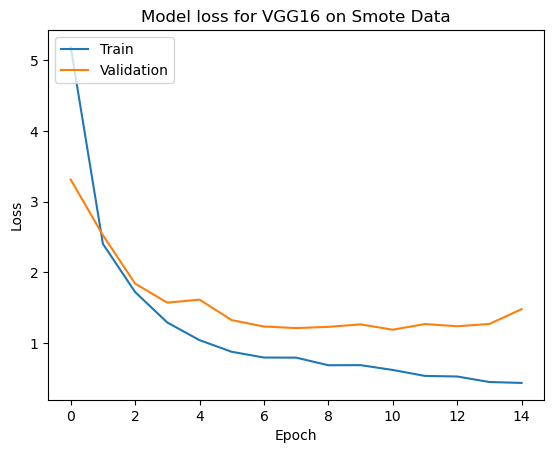

In [11]:
#Execute Training and Evaluation for VGG16 on SMOTE Data
history_vgg_smote, model_vgg_smote = compile_train_save_vgg_smote(train_gen_smote, val_gen_smote)
evaluate_model_vgg_smote(val_gen_smote)

#Visualize Training for VGG16 on SMOTE Data
visualize_training_vgg_smote(history_vgg_smote)
